# Create train and test set

This notebook processes cholera outbreaks and essential climate variable data, merges the data, creates additional features and finally saves a dataset that can be then used to create train and test sets for modeling.

In [1]:
# import packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import matplotlib.pyplot as plt
import gc

In [2]:
# make list of desired years
years = list(np.arange(2010, 2019))

In [3]:
def process_ecv(outbreaks_data, evc_data, ecv):
    
    """
    This functions resamples given ecv data to the district level with an inner spatial join, using the within criterion.
    It then calculates the areal mean of the ecv as well as one and two month lagged means.
    Finally, it drops rows with missing values and returns a geodataframe.    
    """
    
    outbreaks_ecv = gpd.sjoin(evc_data, outbreaks_data[['district', 'geometry']], how='inner', op='within').reset_index(drop=True)
    outbreaks_ecv = outbreaks_ecv.drop('index_right', axis=1)
    
    outbreaks_ecv = outbreaks_ecv.groupby(['district', 'year', 'month']).aggregate('mean').reset_index()
    
    outbreaks_ecv[ecv+'_1m_l'] = outbreaks_ecv.groupby(['district'])[ecv].shift(1)
    outbreaks_ecv[ecv+'_c_1m_l'] = ((outbreaks_ecv[ecv] / outbreaks_ecv[ecv+'_1m_l']) - 1) * 100
    outbreaks_ecv[ecv+'_d_1m_l'] = outbreaks_ecv[ecv+'_c_1m_l'].apply(lambda x: 1 if x > 1 else 0)
    outbreaks_ecv[ecv+'_2m_l'] = outbreaks_ecv.groupby(['district'])[ecv].shift(2)
    outbreaks_ecv[ecv+'_c_2m_l'] = ((outbreaks_ecv[ecv] / outbreaks_ecv[ecv+'_2m_l']) - 1) * 100
    outbreaks_ecv[ecv+'_d_2m_l'] = outbreaks_ecv[ecv+'_c_2m_l'].apply(lambda x: 1 if x > 1 else 0)
    
    outbreaks_ecv = outbreaks_ecv.dropna()
    
    return outbreaks_ecv

## Outbreaks

First, we load the outbreaks data and explore it.

In [4]:
path = '../data/cholera_outbreaks'

In [5]:
file = 'monthly_cholera_outbreaks_per_district_2010_2018.shp'

In [6]:
outbreaks = gpd.read_file(os.path.join(path, file))

In [7]:
# check coordinate reference system
outbreaks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
outbreaks.shape

(466, 6)

In [9]:
outbreaks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   state     466 non-null    object  
 1   district  466 non-null    object  
 2   year      466 non-null    int64   
 3   month     466 non-null    int64   
 4   outbreak  466 non-null    int64   
 5   geometry  466 non-null    geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 22.0+ KB


In [10]:
outbreaks.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."


It might be a good idea to reproject the data to a crs that is suited to this specific region.

In [11]:
# reproject crs to https://epsg.io/7755
outbreaks = outbreaks.to_crs(epsg=7755)

In [12]:
# check new crs
outbreaks.crs

<Projected CRS: EPSG:7755>
Name: WGS 84 / India NSF LCC
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - onshore and offshore. Includes Amandivis, Laccadives, Minicoy, Andaman Islands, Nicobar Islands, and Sikkim.
- bounds: (65.6, 3.87, 97.42, 35.51)
Coordinate Operation:
- name: Survey of India Lambert
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# buffer the district borders by 111000 meters (1 degree)
outbreaks['geometry'] = outbreaks['geometry'].buffer(111000)

In [14]:
outbreaks.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((3764447.443 4629412.289, 3756506.279..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((3511741.355 4351422.986, 3511461.882..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((5480598.578 4308612.598, 5470976.881..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
4,gujarat,bharuch,2010,9,1,"POLYGON ((3128676.356 3764922.012, 3128624.344..."


## Resample ECVs at district level and create lag features

### Sea surface salinity

First we load the data and explore it.

In [15]:
path = '../data/sea_surface_salinity'

In [16]:
file = 'monthly_sss_'+str(years[0])+'.shp'

In [17]:
sss = gpd.read_file(os.path.join(path, file))

The CRS of outbreaks and sea surface salinity need to match.

In [18]:
sss.crs == outbreaks.crs

False

In [19]:
sss = sss.to_crs(epsg=7755)

In [20]:
sss.crs == outbreaks.crs

True

In [21]:
sss.shape

(151452, 4)

In [22]:
sss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 151452 entries, 0 to 151451
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   year      151452 non-null  int64   
 1   month     151452 non-null  int64   
 2   sss       151452 non-null  float64 
 3   geometry  151452 non-null  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 4.6 MB


In [23]:
sss.head()

,year,month,sss,geometry
0,2010,1,35.265869,POINT (1638970.593 1499981.689)
1,2010,2,35.191532,POINT (1638970.593 1499981.689)
2,2010,3,35.426231,POINT (1638970.593 1499981.689)
3,2010,4,35.370430,POINT (1638970.593 1499981.689)
4,2010,5,35.310860,POINT (1638970.593 1499981.689)


In [24]:
# create a dataframe to store the processed data
sss_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'sss', 'sss_1m_l', 'sss_c_1m_l', 'sss_d_1m_l', 'sss_2m_l', 'sss_c_2m_l', 'sss_d_2m_l'])

In [25]:
%%time

# loop over the desired years, read the data, reproject it to the local crs, process the data and append it to the previously created dataframe
for year in years:
    print('Processing {}...'.format(year))
    sss = gpd.read_file(os.path.join(path, 'monthly_sss_'+str(year)+'.shp'))
    sss = sss.to_crs(epsg=7755)
    sss_district_level_temp = process_ecv(outbreaks, sss, 'sss')
    sss_district_level = sss_district_level.append(sss_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 5min 2s, sys: 724 ms, total: 5min 2s
Wall time: 5min 2s


Check out the last file preprocessed to make sure the output is as desired.

In [26]:
sss_district_level.shape

(4590, 10)

In [27]:
sss_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4590 entries, 2 to 611
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   district    4590 non-null   object 
 1   year        4590 non-null   object 
 2   month       4590 non-null   object 
 3   sss         4590 non-null   float64
 4   sss_1m_l    4590 non-null   float64
 5   sss_c_1m_l  4590 non-null   float64
 6   sss_d_1m_l  4590 non-null   object 
 7   sss_2m_l    4590 non-null   float64
 8   sss_c_2m_l  4590 non-null   float64
 9   sss_d_2m_l  4590 non-null   object 
dtypes: float64(5), object(5)
memory usage: 394.5+ KB


In [28]:
sss_district_level.head()

,district,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,sss_c_2m_l,sss_d_2m_l
2,belgaum,2010,3,34.027400,34.600696,-1.656890,0,35.335807,-3.702779,0
3,belgaum,2010,4,34.299124,34.027400,0.798544,0,34.600696,-0.871577,0
4,belgaum,2010,5,34.924089,34.299124,1.822104,1,34.027400,2.635198,1
5,belgaum,2010,6,35.246572,34.924089,0.923383,0,34.299124,2.762312,1
6,belgaum,2010,7,35.282390,35.246572,0.101619,0,34.924089,1.025940,1


In [29]:
# free memory
del [sss, sss_district_level_temp]
gc.collect()

580

### Chlorophyll-a concentration

First we load the data and explore it.

In [30]:
path = '../data/chlorophyll_a_concentration'

In [31]:
file = 'monthly_chlora_'+str(years[0])+'.shp'

In [32]:
chlora = gpd.read_file(os.path.join(path, file))

The CRS of outbreaks and chlorophyll-a concentration need to match.

In [33]:
chlora.crs == outbreaks.crs

False

In [34]:
chlora = chlora.to_crs(epsg=7755)

In [35]:
chlora.crs == outbreaks.crs

True

In [36]:
chlora.shape

(4933904, 4)

In [37]:
chlora.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4933904 entries, 0 to 4933903
Data columns (total 4 columns):
 #   Column    Dtype   
---  ------    -----   
 0   year      int64   
 1   month     int64   
 2   chlora    float64 
 3   geometry  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 150.6 MB


In [38]:
chlora.head()

,year,month,chlora,geometry
0,2010,1,-2.034988,POINT (1635051.143 1491337.847)
1,2010,2,-1.678654,POINT (1635051.143 1491337.847)
2,2010,3,-1.910417,POINT (1635051.143 1491337.847)
3,2010,4,-2.278393,POINT (1635051.143 1491337.847)
4,2010,5,-2.353248,POINT (1635051.143 1491337.847)


In [39]:
# create a dataframe to store the processed data
chlora_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'chlora', 'chlora_1m_l', 'chlora_c_1m_l', 'chlora_d_1m_l', 'chlora_2m_l', 'chlora_c_2m_l', 'chlora_d_2m_l'])

In [40]:
%%time

# loop over the desired years, read the data, reproject it to the local crs, process the data and append it to the previously created dataframe
for year in years:
    print('Processing {}...'.format(year))
    chlora = gpd.read_file(os.path.join(path, 'monthly_chlora_'+str(year)+'.shp'))
    chlora = chlora.to_crs(epsg=7755)
    chlora_district_level_temp = process_ecv(outbreaks, chlora, 'chlora')
    chlora_district_level = chlora_district_level.append(chlora_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 2h 25min 12s, sys: 34.8 s, total: 2h 25min 47s
Wall time: 2h 25min 51s


Check out the last file preprocessed to make sure the output is as desired.

In [41]:
chlora_district_level.shape

(6015, 10)

In [42]:
chlora_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6015 entries, 2 to 770
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district       6015 non-null   object 
 1   year           6015 non-null   object 
 2   month          6015 non-null   object 
 3   chlora         6015 non-null   float64
 4   chlora_1m_l    6015 non-null   float64
 5   chlora_c_1m_l  6015 non-null   float64
 6   chlora_d_1m_l  6015 non-null   object 
 7   chlora_2m_l    6015 non-null   float64
 8   chlora_c_2m_l  6015 non-null   float64
 9   chlora_d_2m_l  6015 non-null   object 
dtypes: float64(5), object(5)
memory usage: 516.9+ KB


In [43]:
chlora_district_level.head()

,district,year,month,chlora,chlora_1m_l,chlora_c_1m_l,chlora_d_1m_l,chlora_2m_l,chlora_c_2m_l,chlora_d_2m_l
2,ahmadabad,2010,3,2.260830,2.251449,0.416650,0,2.406572,-6.056006,0
3,ahmadabad,2010,4,2.274136,2.260830,0.588551,0,2.251449,1.007654,1
4,ahmadabad,2010,5,2.110336,2.274136,-7.202706,0,2.260830,-6.656546,0
5,ahmadabad,2010,6,2.239608,2.110336,6.125648,1,2.274136,-1.518270,0
6,ahmadabad,2010,7,2.183196,2.239608,-2.518839,0,2.110336,3.452514,1


In [44]:
# free memory
del [chlora, chlora_district_level_temp]
gc.collect()

751

### Land surface temperature

First we load the data and explore it.

In [45]:
path = '../data/land_surface_temperature'

In [46]:
file = 'monthly_lst_'+str(years[0])+'.shp'

In [47]:
lst = gpd.read_file(os.path.join(path, file))

The CRS of outbreaks and land surface temperature need to match.

In [48]:
lst.crs == outbreaks.crs

False

In [49]:
lst = lst.to_crs(epsg=7755)

In [50]:
lst.crs == outbreaks.crs

True

In [51]:
lst.shape

(3364371, 4)

In [52]:
lst.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3364371 entries, 0 to 3364370
Data columns (total 4 columns):
 #   Column    Dtype   
---  ------    -----   
 0   year      int64   
 1   month     int64   
 2   lst       float64 
 3   geometry  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 102.7 MB


In [53]:
lst.head()

,year,month,lst,geometry
0,2010,3,298.179993,POINT (6105450.505 1456856.677)
1,2010,4,263.160004,POINT (6105450.505 1456856.677)
2,2010,7,292.839996,POINT (6105450.505 1456856.677)
3,2010,8,281.899994,POINT (6105450.505 1456856.677)
4,2010,11,251.569992,POINT (6105450.505 1456856.677)


In [54]:
# create a dataframe to store the processed data
lst_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'lst', 'lst_1m_l', 'lst_c_1m_l', 'lst_d_1m_l', 'lst_2m_l', 'lst_c_2m_l', 'lst_d_2m_l'])

In [55]:
%%time

# loop over the desired years, read the data, reproject it to the local crs, process the data and append it to the previously created dataframe
for year in years:
    print('Processing {}...'.format(year))
    lst = gpd.read_file(os.path.join(path, 'monthly_lst_'+str(year)+'.shp'))
    lst = lst.to_crs(epsg=7755)
    lst_district_level_temp = process_ecv(outbreaks, lst, 'lst')
    lst_district_level = lst_district_level.append(lst_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 2h 10min 4s, sys: 53.5 s, total: 2h 10min 57s
Wall time: 2h 11min


Check out the last file preprocessed to make sure the output is as desired.

In [56]:
lst_district_level.shape

(15587, 10)

In [57]:
lst_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15587 entries, 2 to 2093
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   district    15587 non-null  object 
 1   year        15587 non-null  object 
 2   month       15587 non-null  object 
 3   lst         15587 non-null  float64
 4   lst_1m_l    15587 non-null  float64
 5   lst_c_1m_l  15587 non-null  float64
 6   lst_d_1m_l  15587 non-null  object 
 7   lst_2m_l    15587 non-null  float64
 8   lst_c_2m_l  15587 non-null  float64
 9   lst_d_2m_l  15587 non-null  object 
dtypes: float64(5), object(5)
memory usage: 1.3+ MB


In [58]:
lst_district_level.head()

,district,year,month,lst,lst_1m_l,lst_c_1m_l,lst_d_1m_l,lst_2m_l,lst_c_2m_l,lst_d_2m_l
2,ahmadabad,2010,3,325.963631,318.111811,2.468258,1,313.017665,4.135858,1
3,ahmadabad,2010,4,329.984802,325.963631,1.233626,1,318.111811,3.732333,1
4,ahmadabad,2010,5,334.093161,329.984802,1.245015,1,325.963631,2.493999,1
5,ahmadabad,2010,6,329.799811,334.093161,-1.285076,0,329.984802,-0.056061,0
6,ahmadabad,2010,7,275.639148,329.799811,-16.422284,0,334.093161,-17.496321,0


In [59]:
# free memory
del [lst, lst_district_level_temp]
gc.collect()

473

## Merge features and target

Next, we merge districts and ECV data.

In [124]:
path = '../data/cholera_outbreaks'

In [125]:
file = 'monthly_cholera_outbreaks_per_district_2010_2018.shp'

In [126]:
# check the number of distinct districts and their original, unbuffered geometries
distinct_districts = gpd.read_file(os.path.join(path, file))
distinct_districts = distinct_districts[['state', 'district', 'geometry']].drop_duplicates()
distinct_districts.shape

(178, 3)

In [127]:
# merge distinct districts and geometries with sea surface salinity
train_test_sss = pd.merge(distinct_districts, sss_district_level, how='inner', on='district')
train_test_sss.shape

(4590, 12)

In [128]:
# merge distinct districts and geometries with chlorophyll-a concentration
train_test_chlora = pd.merge(distinct_districts, chlora_district_level, how='inner', on='district')
train_test_chlora.shape

(6015, 12)

In [129]:
# merge distinct districts and geometries with land surface temperature
train_test_lst = pd.merge(distinct_districts, lst_district_level, how='inner', on='district')
train_test_lst.shape

(15587, 12)

In [131]:
# merge ecv data and outbreaks on district, year and month
train_test = pd.merge(train_test_sss, train_test_chlora.drop(['state', 'geometry'], axis=1), how='inner', on=['district', 'year', 'month'])
train_test = pd.merge(train_test, train_test_lst.drop(['state', 'geometry'], axis=1), how='inner', on=['district', 'year', 'month'])
train_test = pd.merge(train_test, outbreaks[['district', 'year', 'month', 'outbreak']], how='left', on=['district', 'year', 'month']).reset_index(drop=True)

In [132]:
train_test.shape

(4325, 27)

In [133]:
train_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   state          4325 non-null   object  
 1   district       4325 non-null   object  
 2   geometry       4325 non-null   geometry
 3   year           4325 non-null   object  
 4   month          4325 non-null   object  
 5   sss            4325 non-null   float64 
 6   sss_1m_l       4325 non-null   float64 
 7   sss_c_1m_l     4325 non-null   float64 
 8   sss_d_1m_l     4325 non-null   object  
 9   sss_2m_l       4325 non-null   float64 
 10  sss_c_2m_l     4325 non-null   float64 
 11  sss_d_2m_l     4325 non-null   object  
 12  chlora         4325 non-null   float64 
 13  chlora_1m_l    4325 non-null   float64 
 14  chlora_c_1m_l  4325 non-null   float64 
 15  chlora_d_1m_l  4325 non-null   object  
 16  chlora_2m_l    4325 non-null   float64 
 17  chlora_c_2m_l  4325 non-n

In [134]:
# relace missing values in the target with 0
train_test['outbreak'] = train_test['outbreak'].fillna(0)

In [135]:
train_test['outbreak'].value_counts()

0.0    4216
1.0     109
Name: outbreak, dtype: int64

In [136]:
train_test

,state,district,geometry,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,...,chlora_c_2m_l,chlora_d_2m_l,lst,lst_1m_l,lst_c_1m_l,lst_d_1m_l,lst_2m_l,lst_c_2m_l,lst_d_2m_l,outbreak
0,karnataka,belgaum,"POLYGON ((74.75089 15.49199, 74.74472 15.48939...",2010,3,34.027400,34.600696,-1.656890,0,35.335807,...,640.739850,1,326.305884,320.030061,1.961011,1,314.014733,3.914196,1,0.0
1,karnataka,belgaum,"POLYGON ((74.75089 15.49199, 74.74472 15.48939...",2010,4,34.299124,34.027400,0.798544,0,34.600696,...,21.729825,1,330.424175,326.305884,1.262095,1,320.030061,3.247856,1,0.0
2,karnataka,belgaum,"POLYGON ((74.75089 15.49199, 74.74472 15.48939...",2010,5,34.924089,34.299124,1.822104,1,34.027400,...,-2.970501,0,332.450231,330.424175,0.613168,0,326.305884,1.883002,1,0.0
3,karnataka,belgaum,"POLYGON ((74.75089 15.49199, 74.74472 15.48939...",2010,6,35.246572,34.924089,0.923383,0,34.299124,...,-74.244754,0,313.549617,332.450231,-5.685246,0,330.424175,-5.106938,0,0.0
4,karnataka,belgaum,"POLYGON ((74.75089 15.49199, 74.74472 15.48939...",2010,7,35.282390,35.246572,0.101619,0,34.924089,...,-157.276383,0,304.003108,313.549617,-3.044656,0,332.450231,-8.556807,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,kerala,pathanamthitta,"POLYGON ((76.64102 9.14179, 76.65238 9.14195, ...",2018,8,33.805684,34.235850,-1.256476,0,34.611369,...,-1751.727429,0,319.462127,316.543710,0.921963,0,309.711798,3.148194,1,0.0
4321,kerala,pathanamthitta,"POLYGON ((76.64102 9.14179, 76.65238 9.14195, ...",2018,9,34.660524,33.805684,2.528685,1,34.235850,...,-568.016212,0,322.904377,319.462127,1.077514,1,316.543710,2.009412,1,0.0
4322,kerala,pathanamthitta,"POLYGON ((76.64102 9.14179, 76.65238 9.14195, ...",2018,10,35.295586,34.660524,1.832235,1,33.805684,...,-154.907944,0,312.129742,322.904377,-3.336788,0,319.462127,-2.295228,0,0.0
4323,kerala,pathanamthitta,"POLYGON ((76.64102 9.14179, 76.65238 9.14195, ...",2018,11,35.153257,35.295586,-0.403247,0,34.660524,...,-263.101181,0,308.569854,312.129742,-1.140516,0,322.904377,-4.439247,0,0.0


## Map district to location

Next, we need to figure out which district is on the west and which is on the east coast of India. The following is a rough approach that should suffice for now. The southernmost point of mainland India is Cape Comorin. We check whether each district's centroid is east or west of Cape Comorin and thereby decide which coastal location to assign to each district.

In [137]:
# geocode Cape Comorin
cape_comorin = geocode('Cape Comorin', provider='nominatim', user_agent='cholera_risk_modeling', timeout=4)

In [138]:
cape_comorin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The CRS of Cape Comoring and our data need to match.

In [139]:
# reproject data to local crs
cape_comorin = cape_comorin.to_crs(epsg=7755)
train_test = train_test.to_crs(epsg=7755)

In [140]:
cape_comorin.crs == train_test.crs

True

In [141]:
cape_comorin

,geometry,address
0,POINT (3725305.123 2252761.856),"Cape Comorin, Vavaturai, Agastheeswaram, Kanya..."


In [142]:
# check the coordinates of Cape Comorin
split_point = cape_comorin.loc[0, 'geometry']
print(split_point)
print(split_point.x)
print(split_point.y)

POINT (3725305.123427642 2252761.855500367)
3725305.1234276416
2252761.8555003675


In [143]:
# get district centroids
train_test['centroid'] = train_test.centroid

In [144]:
# check whether district centroids are west or east of Cape Comorin
train_test['location'] = train_test.apply(lambda x: 'west' if x['centroid'].x < split_point.x else 'east', axis=1)

In [145]:
train_test.head()

,state,district,geometry,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,...,lst,lst_1m_l,lst_c_1m_l,lst_d_1m_l,lst_2m_l,lst_c_2m_l,lst_d_2m_l,outbreak,centroid,location
0,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,3,34.027400,34.600696,-1.656890,0,35.335807,...,326.305884,320.030061,1.961011,1,314.014733,3.914196,1,0.0,POINT (3452531.253 3151629.624),west
1,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,4,34.299124,34.027400,0.798544,0,34.600696,...,330.424175,326.305884,1.262095,1,320.030061,3.247856,1,0.0,POINT (3452531.253 3151629.624),west
2,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,5,34.924089,34.299124,1.822104,1,34.027400,...,332.450231,330.424175,0.613168,0,326.305884,1.883002,1,0.0,POINT (3452531.253 3151629.624),west
3,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,6,35.246572,34.924089,0.923383,0,34.299124,...,313.549617,332.450231,-5.685246,0,330.424175,-5.106938,0,0.0,POINT (3452531.253 3151629.624),west
4,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,7,35.282390,35.246572,0.101619,0,34.924089,...,304.003108,313.549617,-3.044656,0,332.450231,-8.556807,0,0.0,POINT (3452531.253 3151629.624),west


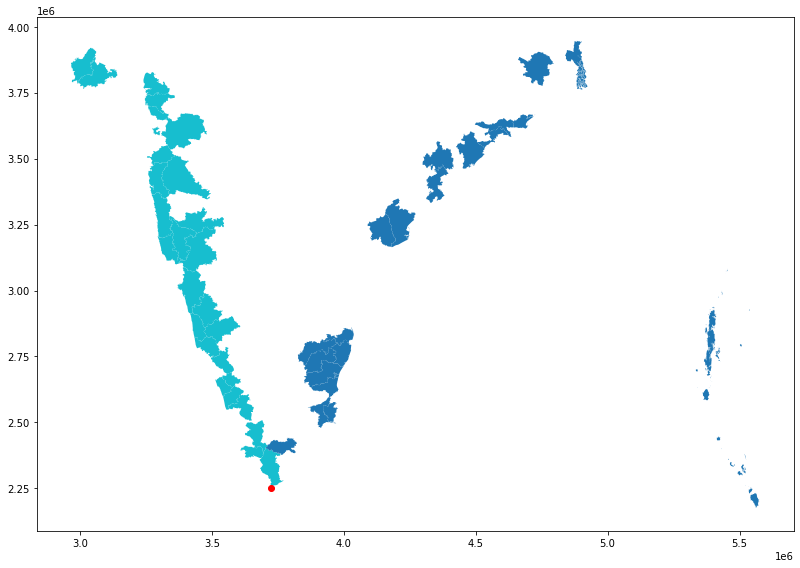

In [146]:
# visually check whether the assignment makes intuitive sense
fig, ax = plt.subplots(figsize=(12,8))
train_test[['geometry', 'location']].drop_duplicates().plot(ax=ax, column='location')
cape_comorin.plot(ax=ax, color='red')
plt.tight_layout()

In [147]:
# drop centriod column because it is not needed anymore
train_test = train_test.drop('centroid', axis=1)

## Map month to season

Next, we need to map the months to their respective season.

In [148]:
# create dictionary with month to season mapping
seasons = {1: 'winter',
           2: 'winter',
           3: 'pre_monsoon',
           4: 'pre_monsoon',
           5: 'pre_monsoon',
           6: 'monsoon',
           7: 'monsoon',
           8: 'monsoon',
           9: 'monsoon',
           10: 'post_monsoon',
           11: 'post_monsoon',
           12: 'post_monsoon'}

In [149]:
# apply mapping
train_test['season'] = train_test['month'].map(seasons)

In [150]:
train_test.head()

,state,district,geometry,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,...,lst,lst_1m_l,lst_c_1m_l,lst_d_1m_l,lst_2m_l,lst_c_2m_l,lst_d_2m_l,outbreak,location,season
0,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,3,34.027400,34.600696,-1.656890,0,35.335807,...,326.305884,320.030061,1.961011,1,314.014733,3.914196,1,0.0,west,pre_monsoon
1,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,4,34.299124,34.027400,0.798544,0,34.600696,...,330.424175,326.305884,1.262095,1,320.030061,3.247856,1,0.0,west,pre_monsoon
2,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,5,34.924089,34.299124,1.822104,1,34.027400,...,332.450231,330.424175,0.613168,0,326.305884,1.883002,1,0.0,west,pre_monsoon
3,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,6,35.246572,34.924089,0.923383,0,34.299124,...,313.549617,332.450231,-5.685246,0,330.424175,-5.106938,0,0.0,west,monsoon
4,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,7,35.282390,35.246572,0.101619,0,34.924089,...,304.003108,313.549617,-3.044656,0,332.450231,-8.556807,0,0.0,west,monsoon


## One-hot encode categorical features

We also need to one-hot encode the categorical features in our data.

In [151]:
location_dummies = pd.get_dummies(train_test['location'])

In [152]:
train_test = pd.concat([train_test, location_dummies], axis=1).drop('location', axis=1)

In [153]:
season_dummies = pd.get_dummies(train_test['season'])

In [154]:
train_test = pd.concat([train_test, season_dummies], axis=1).drop('season', axis=1)

In [155]:
train_test.head()

,state,district,geometry,year,month,sss,sss_1m_l,sss_c_1m_l,sss_d_1m_l,sss_2m_l,...,lst_d_1m_l,lst_2m_l,lst_c_2m_l,lst_d_2m_l,outbreak,east,west,monsoon,post_monsoon,pre_monsoon
0,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,3,34.027400,34.600696,-1.656890,0,35.335807,...,1,314.014733,3.914196,1,0.0,0,1,0,0,1
1,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,4,34.299124,34.027400,0.798544,0,34.600696,...,1,320.030061,3.247856,1,0.0,0,1,0,0,1
2,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,5,34.924089,34.299124,1.822104,1,34.027400,...,0,326.305884,1.883002,1,0.0,0,1,0,0,1
3,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,6,35.246572,34.924089,0.923383,0,34.299124,...,0,330.424175,-5.106938,0,0.0,0,1,1,0,0
4,karnataka,belgaum,"POLYGON ((3441889.619 3083540.901, 3441223.031...",2010,7,35.282390,35.246572,0.101619,0,34.924089,...,0,332.450231,-8.556807,0,0.0,0,1,1,0,0


## Save final geodataframe

Finally, we save our data in shapefile format.

In [156]:
train_test.to_file('../data/train_test.shp')